# Global imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Qiskit
from qiskit import BasicAer
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.datasets import ad_hoc_data

# Scikit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores
# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QKSVM import QSVM_QKT

seed = 12345

# Qiskit Ad Hoc dataset

In [2]:
np.random.seed(seed=77)
algorithm_globals.random_seed = seed

# generate the dataset
adhoc_dimension = 2
X, y, _, _, adhoc_total = ad_hoc_data(
    training_size=200,
    test_size=2,
    n=adhoc_dimension,
    gap=0.2,
    plot_data=False,
    one_hot=False,
    include_sample_total=True
)
y = 2*y-1

print(f"Dataset statistics: {Counter(y)}")

Dataset statistics: Counter({-1: 200, 1: 200})


In [3]:
train_size = 50
test_size = 50
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 25, -1: 25})
Testing target statistics: Counter({-1: 25, 1: 25})


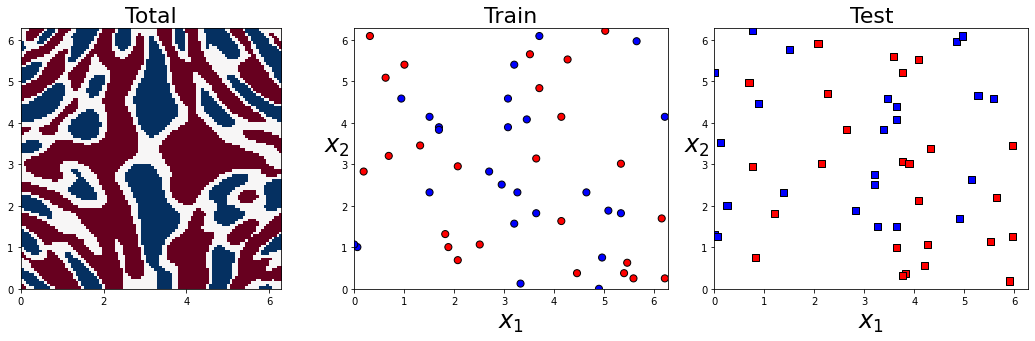

In [4]:
# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# visualize the dataset
xmin = 0; xmax = 2*np.pi
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=22)
ax1.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap=plt.cm.RdBu_r,
    extent=axes,
)

ax2.set_title("Train", fontsize=22)
plot_dataset(X_train, y_train, ax2, axes, marker='o', size=50, stepsize=1.0)
ax2.grid(False)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='s', size=50, stepsize=1.0)
ax3.grid(False)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

## Visualize the classifier

In [5]:
def plot_results(clf, N=20):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap=plt.cm.RdBu_r,
        extent=axes,
    )
    plot_predictions(clf, axs[1], axes, N=N)
    plot_dataset(X_test, y_test, axs[1], axes, stepsize=1.0)
    plot_decisions(clf, axs[2], axes, N=N)
    plot_dataset(X_test, y_test, axs[2], axes, stepsize=1.0)
    plt.tight_layout()
    plt.show()   

# RBF kernel

Best grid search parameters: {'C': 5, 'gamma': 1.0}
Best training score: 0.6858974358974359

Train set:
   Balanced accuracy:  0.96
                  F1:  0.96
             ROC_AUC:  1.00
                 MCC:  0.92

Test set:
   Balanced accuracy:  0.72
                  F1:  0.72
             ROC_AUC:  0.73
                 MCC:  0.44


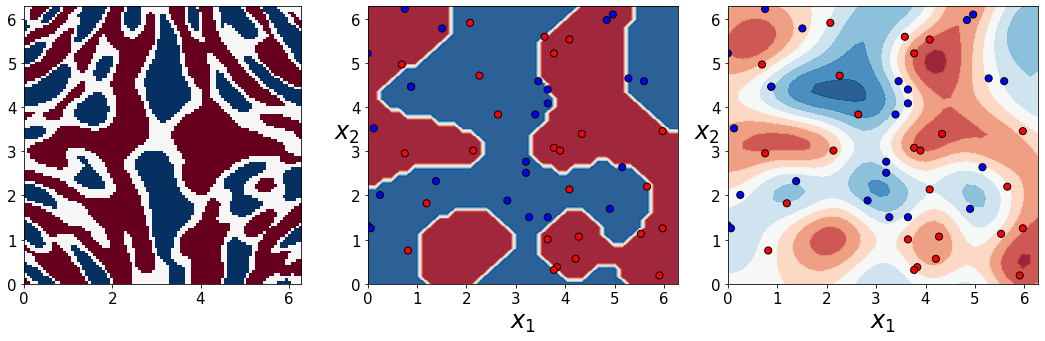

In [6]:
np.random.seed(seed)

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

scores_ = get_scores(clf.best_estimator_, X_train, y_train)
print_scores(scores_, title='Train set:')

scores_ = get_scores(clf.best_estimator_, X_test, y_test)
print_scores(scores_, title='Test set:')

plot_results(clf.best_estimator_, N=40)

# QKT SVM

     ┌──────────────┐           ┌──────────┐ ┌──────────┐ ┌──────────────┐            ┌──────────┐ ┌───────────┐ »
q_0: ┤ Ry(2.0*x[0]) ├──■─────■──┤ Rz(θ[0]) ├─┤ Rx(θ[4]) ├─┤ Ry(2.0*x[0]) ├──■─────■───┤ Rz(θ[8]) ├─┤ Rx(θ[12]) ├─»
     ├──────────────┤  │     │  ├──────────┤ ├──────────┤ ├──────────────┤  │     │   ├──────────┤ ├───────────┤ »
q_1: ┤ Ry(2.0*x[1]) ├──■──■──┼──┤ Rz(θ[1]) ├─┤ Rx(θ[5]) ├─┤ Ry(2.0*x[1]) ├──■──■──┼───┤ Rz(θ[9]) ├─┤ Rx(θ[13]) ├─»
     ├──────────────┤     │  │  ├──────────┤ ├──────────┤ ├──────────────┤     │  │  ┌┴──────────┤ ├───────────┤ »
q_2: ┤ Ry(2.0*x[0]) ├──■──■──┼──┤ Rz(θ[2]) ├─┤ Rx(θ[6]) ├─┤ Ry(2.0*x[0]) ├──■──■──┼──┤ Rz(θ[10]) ├─┤ Rx(θ[14]) ├─»
     ├──────────────┤  │     │  ├──────────┤ ├──────────┤ ├──────────────┤  │     │  ├───────────┤ ├───────────┤ »
q_3: ┤ Ry(2.0*x[1]) ├──■─────■──┤ Rz(θ[3]) ├─┤ Rx(θ[7]) ├─┤ Ry(2.0*x[1]) ├──■─────■──┤ Rz(θ[11]) ├─┤ Rx(θ[15]) ├─»
     └──────────────┘           └──────────┘ └──────────┘ └──────────────┘      

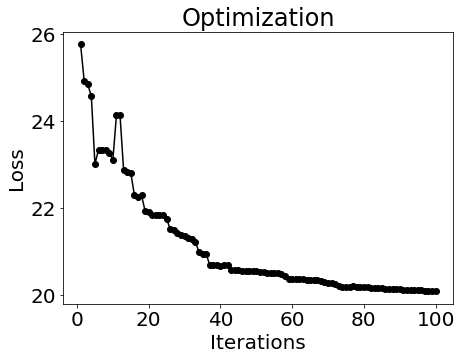


Train scores:
   Balanced accuracy:  0.94
                  F1:  0.94
             ROC_AUC:  0.99
                 MCC:  0.89

Test scores:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.86
                 MCC:  0.58


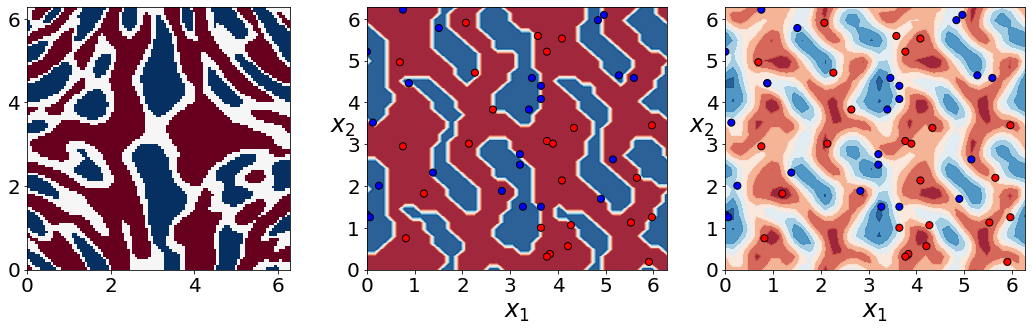

In [7]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=4,
    gates=['RY', 'cz', 'rz', 'rx', ], entanglement='ring',
    repeat=True, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌──────────────┐           ┌──────────┐  ┌──────────┐ ┌──────────────┐           ┌───────────┐ ┌───────────┐ »
q_0: ┤ Ry(2.0*x[0]) ├──■─────■──┤ Rz(θ[0]) ├──┤ Rx(θ[8]) ├─┤ Ry(2.0*x[0]) ├──■─────■──┤ Rz(θ[16]) ├─┤ Rx(θ[24]) ├─»
     ├──────────────┤  │     │  ├──────────┤  ├──────────┤ ├──────────────┤  │     │  ├───────────┤ ├───────────┤ »
q_1: ┤ Ry(2.0*x[1]) ├──■──■──┼──┤ Rz(θ[1]) ├──┤ Rx(θ[9]) ├─┤ Ry(2.0*x[1]) ├──■──■──┼──┤ Rz(θ[17]) ├─┤ Rx(θ[25]) ├─»
     ├──────────────┤     │  │  ├──────────┤ ┌┴──────────┤ ├──────────────┤     │  │  ├───────────┤ ├───────────┤ »
q_2: ┤ Ry(2.0*x[0]) ├──■──■──┼──┤ Rz(θ[2]) ├─┤ Rx(θ[10]) ├─┤ Ry(2.0*x[0]) ├──■──■──┼──┤ Rz(θ[18]) ├─┤ Rx(θ[26]) ├─»
     ├──────────────┤  │     │  ├──────────┤ ├───────────┤ ├──────────────┤  │     │  ├───────────┤ ├───────────┤ »
q_3: ┤ Ry(2.0*x[1]) ├──■──■──┼──┤ Rz(θ[3]) ├─┤ Rx(θ[11]) ├─┤ Ry(2.0*x[1]) ├──■──■──┼──┤ Rz(θ[19]) ├─┤ Rx(θ[27]) ├─»
     ├──────────────┤     │  │  ├──────────┤ ├───────────┤ ├────────────

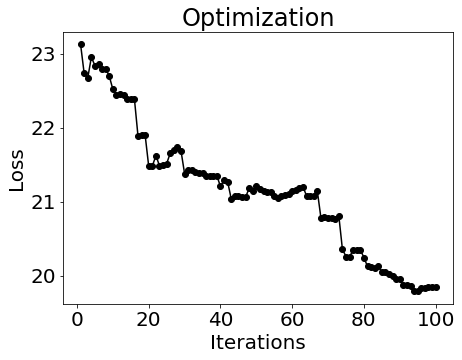


Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  1.00
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.68
                  F1:  0.67
             ROC_AUC:  0.84
                 MCC:  0.39


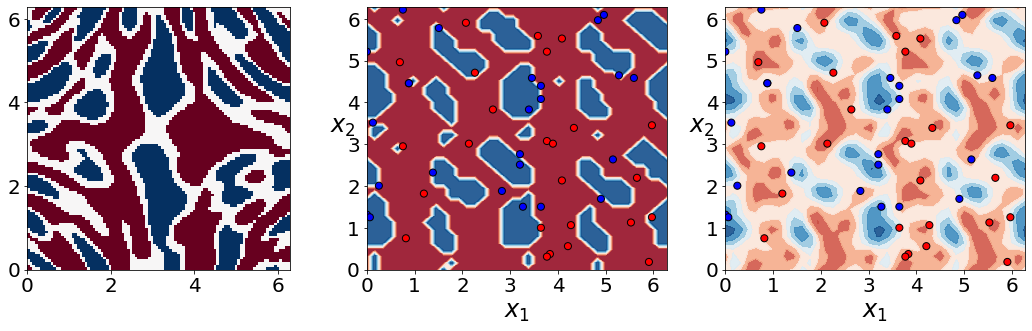

In [8]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=4,
    gates=['RY', 'cz', 'rz', 'rx', ], entanglement='ring',
    repeat=True, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌───┐ ┌──────────────┐ ┌──────────┐                         ┌──────────┐ ┌───┐ ┌──────────────┐  ┌──────────┐ »
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├─┤ Ry(θ[0]) ├──────■──────────────────┤ Rx(θ[7]) ├─┤ H ├─┤ Rz(2.0*x[0]) ├──┤ Ry(θ[8]) ├─»
     ├───┤ ├──────────────┤ ├──────────┤ ┌────┴─────┐            └────┬─────┘ ├───┤ ├──────────────┤  ├──────────┤ »
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Ry(θ[1]) ├─┤ Rx(θ[4]) ├─────■───────────┼───────┤ H ├─┤ Rz(2.0*x[1]) ├──┤ Ry(θ[9]) ├─»
     ├───┤ ├──────────────┤ ├──────────┤ └──────────┘┌────┴─────┐     │       ├───┤ ├──────────────┤ ┌┴──────────┤ »
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├─┤ Ry(θ[2]) ├──────■──────┤ Rx(θ[6]) ├─────┼───────┤ H ├─┤ Rz(2.0*x[0]) ├─┤ Ry(θ[10]) ├─»
     ├───┤ ├──────────────┤ ├──────────┤ ┌────┴─────┐└──────────┘     │       ├───┤ ├──────────────┤ ├───────────┤ »
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Ry(θ[3]) ├─┤ Rx(θ[5]) ├─────────────────■───────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Ry(θ[11]) ├─»
     └───┘ └──────────────┘ └──────────┘ └──────────┘           

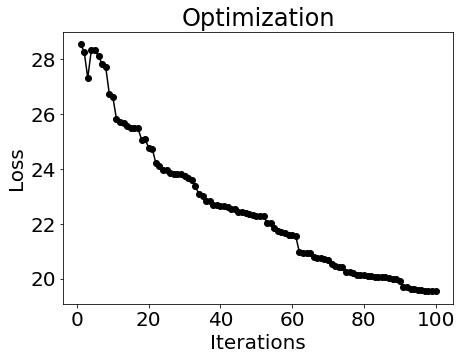


Train scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.98
                 MCC:  0.77

Test scores:
   Balanced accuracy:  0.70
                  F1:  0.69
             ROC_AUC:  0.87
                 MCC:  0.42


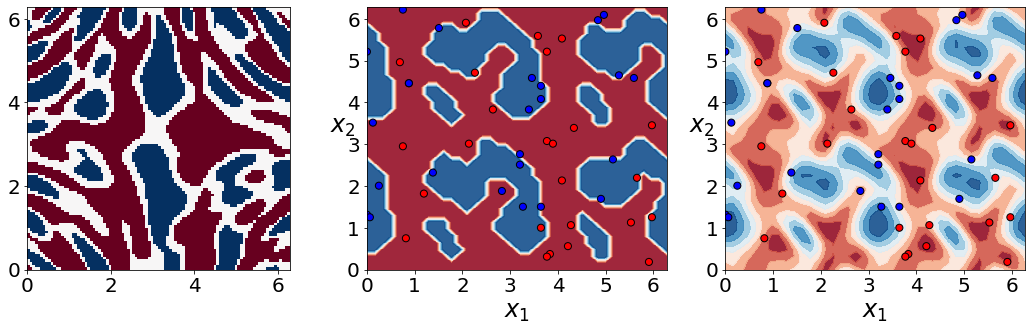

In [9]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=4,
    gates=['H', 'RZ', 'ry', 'crx', ], entanglement='ring',
    repeat=True, scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌───┐ ┌──────────────┐      ┌───┐ ┌──────────┐ ┌──────────┐             ┌──────────┐ ┌───┐ ┌──────────────┐      »
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─┤ Rx(θ[0]) ├─┤ Rz(θ[2]) ├──────■──────┤ Rx(θ[5]) ├─┤ H ├─┤ Rz(2.0*x[0]) ├───■──»
     ├───┤ ├──────────────┤ ┌─┴─┐└─┬─┘ ├──────────┤ ├──────────┤ ┌────┴─────┐└────┬─────┘ ├───┤ ├──────────────┤ ┌─┴─┐»
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───┤ Rx(θ[1]) ├─┤ Rz(θ[3]) ├─┤ Rx(θ[4]) ├─────■───────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├»
     └───┘ └──────────────┘ └───┘      └──────────┘ └──────────┘ └──────────┘             └───┘ └──────────────┘ └───┘»
«     ┌───┐ ┌──────────┐ ┌──────────┐              ┌───────────┐ 
«q_0: ┤ X ├─┤ Rx(θ[6]) ├─┤ Rz(θ[8]) ├───────■──────┤ Rx(θ[11]) ├─
«     └─┬─┘ ├──────────┤ ├──────────┤ ┌─────┴─────┐└─────┬─────┘ 
«q_1: ──■───┤ Rx(θ[7]) ├─┤ Rz(θ[9]) ├─┤ Rx(θ[10]) ├──────■───────
«           └──────────┘ └──────────┘ └───────────┘              


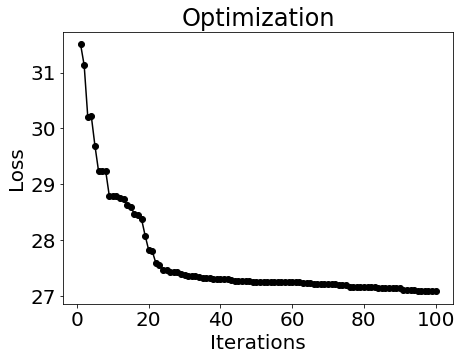


Train scores:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.89
                 MCC:  0.68

Test scores:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.87
                 MCC:  0.56


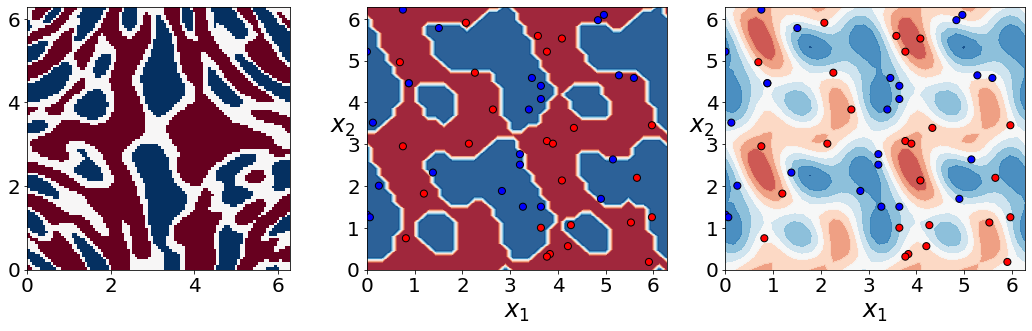

In [10]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['H', 'RZ', 'CX', 'rx', 'rz', 'crx', ], entanglement='ring',
    repeat=True, scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌──────────┐ ┌──────────┐             ┌──────────┐ ┌───┐ ┌──────────────┐      ┌───┐ ┌──────────┐ ┌──────────┐ »
q_0: ┤ Rx(θ[0]) ├─┤ Rz(θ[2]) ├──────■──────┤ Rx(θ[5]) ├─┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─┤ Rx(θ[6]) ├─┤ Rz(θ[8]) ├─»
     ├──────────┤ ├──────────┤ ┌────┴─────┐└────┬─────┘ ├───┤ ├──────────────┤ ┌─┴─┐└─┬─┘ ├──────────┤ ├──────────┤ »
q_1: ┤ Rx(θ[1]) ├─┤ Rz(θ[3]) ├─┤ Rx(θ[4]) ├─────■───────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───┤ Rx(θ[7]) ├─┤ Rz(θ[9]) ├─»
     └──────────┘ └──────────┘ └──────────┘             └───┘ └──────────────┘ └───┘      └──────────┘ └──────────┘ »
«                  ┌───────────┐ ┌───┐ ┌──────────────┐      ┌───┐ 
«q_0: ──────■──────┤ Rx(θ[11]) ├─┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─
«     ┌─────┴─────┐└─────┬─────┘ ├───┤ ├──────────────┤ ┌─┴─┐└─┬─┘ 
«q_1: ┤ Rx(θ[10]) ├──────■───────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───
«     └───────────┘              └───┘ └──────────────┘ └───┘      


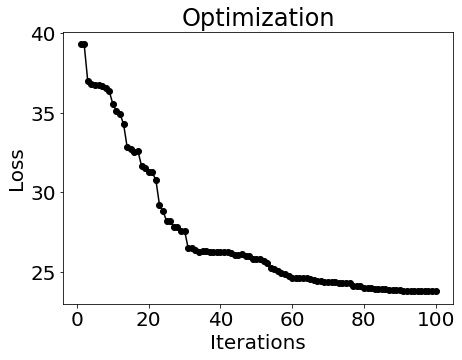


Train scores:
   Balanced accuracy:  0.86
                  F1:  0.86
             ROC_AUC:  0.90
                 MCC:  0.72

Test scores:
   Balanced accuracy:  0.74
                  F1:  0.74
             ROC_AUC:  0.85
                 MCC:  0.49


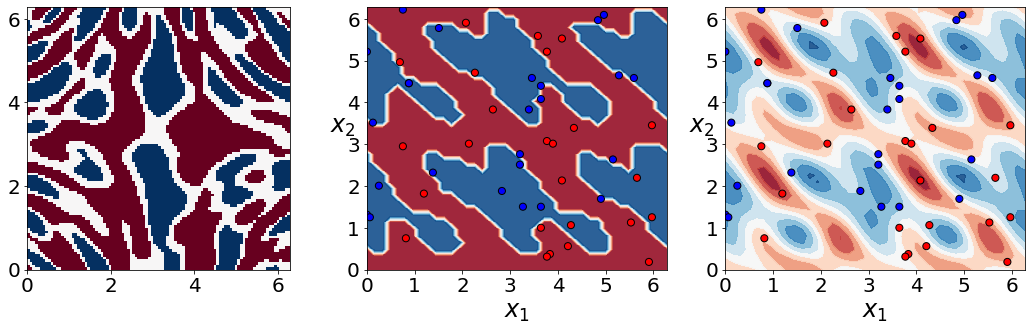

In [11]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['rx', 'rz', 'crx', 'H', 'RZ', 'CX'], entanglement='ring',
    repeat=True, scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌───┐ ┌──────────────┐      ┌───┐ ┌──────────┐ ┌──────────┐             ┌──────────┐ ┌──────────┐ ┌──────────┐ »
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─┤ Rx(θ[0]) ├─┤ Rz(θ[2]) ├──────■──────┤ Rx(θ[5]) ├─┤ Rx(θ[6]) ├─┤ Rz(θ[8]) ├─»
     ├───┤ ├──────────────┤ ┌─┴─┐└─┬─┘ ├──────────┤ ├──────────┤ ┌────┴─────┐└────┬─────┘ ├──────────┤ ├──────────┤ »
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───┤ Rx(θ[1]) ├─┤ Rz(θ[3]) ├─┤ Rx(θ[4]) ├─────■───────┤ Rx(θ[7]) ├─┤ Rz(θ[9]) ├─»
     └───┘ └──────────────┘ └───┘      └──────────┘ └──────────┘ └──────────┘             └──────────┘ └──────────┘ »
«     ┌───┐ ┌──────────────┐      ┌───┐ ┌───────────┐ ┌───────────┐              ┌───────────┐ ┌───────────┐ »
«q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─┤ Rx(θ[10]) ├─┤ Rz(θ[12]) ├───────■──────┤ Rx(θ[15]) ├─┤ Rx(θ[16]) ├─»
«     ├───┤ ├──────────────┤ ┌─┴─┐└─┬─┘ ├───────────┤ ├───────────┤ ┌─────┴─────┐└─────┬─────┘ ├───────────┤ »
«q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───┤ Rx(θ[11]) ├─┤ Rz(θ[13]) ├─┤ Rx(θ[14

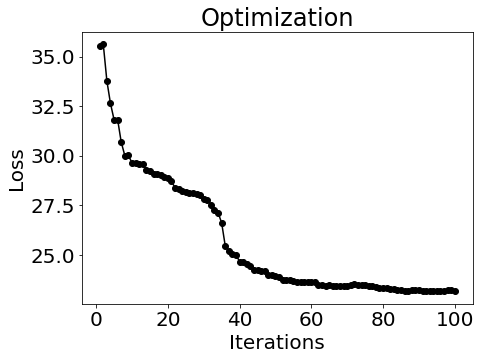


Train scores:
   Balanced accuracy:  0.86
                  F1:  0.86
             ROC_AUC:  0.91
                 MCC:  0.73

Test scores:
   Balanced accuracy:  0.70
                  F1:  0.68
             ROC_AUC:  0.87
                 MCC:  0.45


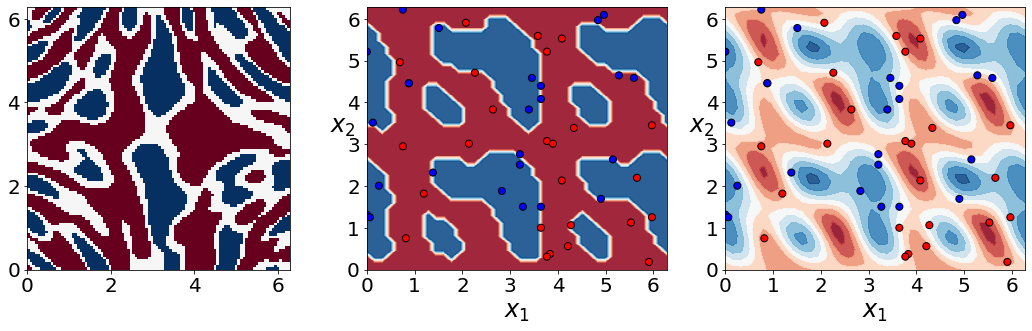

In [12]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['H', 'RZ', 'CX', 'rx', 'rz', 'crx', 'rx', 'rz'], entanglement='ring',
    repeat=True, scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

# TESTS

In [31]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=1,
    gates=['ry', 'rz', 'cz', ], entanglement='linear',
    repeat=True, scale=False, alpha=2.0
)

print(fm.alpha)

for i in range(2):
    fm.h(i)
    fm.rz(fm.encod_params[i], i)

for i in range(2, fm.num_qubits):
    t = 2.0*(np.pi-fm.encod_params[i%fm.num_features]/fm.alpha)*(np.pi-fm.encod_params[(i+1)%fm.num_features]/fm.alpha)
    fm.h(i)
    fm.rz(t, i)

print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100, scale0=2.0,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test, y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)


	Encoding circuit is not specified. Is it what you are aiming at?



CircuitError: 'Cannot bind parameters (α) not present in the circuit.'


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌──────────┐ ┌──────────┐        ┌───┐        ┌───────────────┐        
q_0: ┤ Ry(θ[1]) ├─┤ Rz(θ[5]) ├──■─────┤ H ├────────┤ Rz(x[0]*θ[0]) ├────────
     ├──────────┤ ├──────────┤  │     ├───┤        ├───────────────┤        
q_1: ┤ Ry(θ[2]) ├─┤ Rz(θ[6]) ├──■──■──┤ H ├────────┤ Rz(x[1]*θ[0]) ├────────
     ├──────────┤ ├──────────┤     │  ├───┤┌───────┴───────────────┴───────┐
q_2: ┤ Ry(θ[3]) ├─┤ Rz(θ[7]) ├──■──■──┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     ├──────────┤ ├──────────┤  │     ├───┤├───────────────────────────────┤
q_3: ┤ Ry(θ[4]) ├─┤ Rz(θ[8]) ├──■─────┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     └──────────┘ └──────────┘        └───┘└───────────────────────────────┘


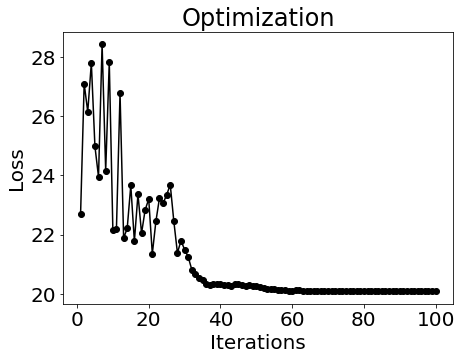


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.93
                 MCC:  0.69


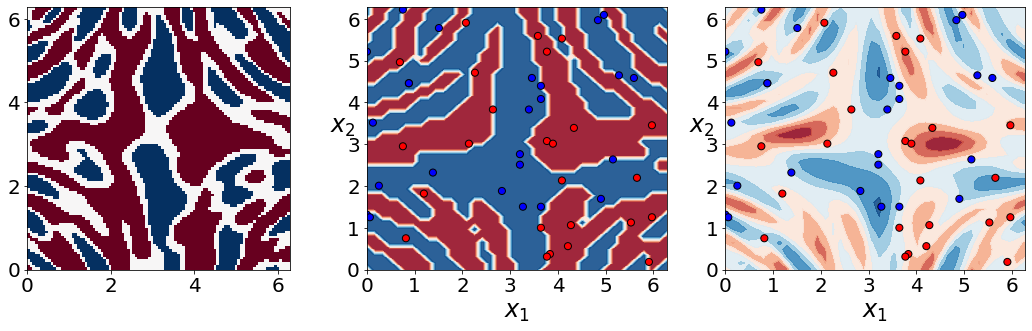

In [ ]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=1,
    gates=['ry', 'rz', 'cz', ], entanglement='linear',
    repeat=True, scale=True, alpha=2.0
)

for i in range(2):
    fm.h(i)
    fm.rz(fm.encod_params[i], i)

for i in range(2, fm.num_qubits):
    t = 2.0*(np.pi-fm.encod_params[i%fm.num_features]/fm.alpha)*(np.pi-fm.encod_params[(i+1)%fm.num_features]/fm.alpha)
    fm.h(i)
    fm.rz(t, i)

print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100, scale0=2.0,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test, y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌──────────┐ ┌──────────┐        ┌───┐        ┌───────────────┐        
q_0: ┤ Ry(θ[1]) ├─┤ Rx(θ[5]) ├──■─────┤ H ├────────┤ Rz(x[0]*θ[0]) ├────────
     ├──────────┤ ├──────────┤  │     ├───┤        ├───────────────┤        
q_1: ┤ Ry(θ[2]) ├─┤ Rx(θ[6]) ├──■──■──┤ H ├────────┤ Rz(x[1]*θ[0]) ├────────
     ├──────────┤ ├──────────┤     │  ├───┤┌───────┴───────────────┴───────┐
q_2: ┤ Ry(θ[3]) ├─┤ Rx(θ[7]) ├──■──■──┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     ├──────────┤ ├──────────┤  │     ├───┤├───────────────────────────────┤
q_3: ┤ Ry(θ[4]) ├─┤ Rx(θ[8]) ├──■─────┤ H ├┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     └──────────┘ └──────────┘        └───┘└───────────────────────────────┘


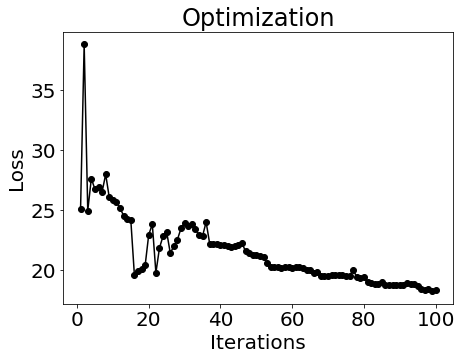


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.90
                 MCC:  0.69


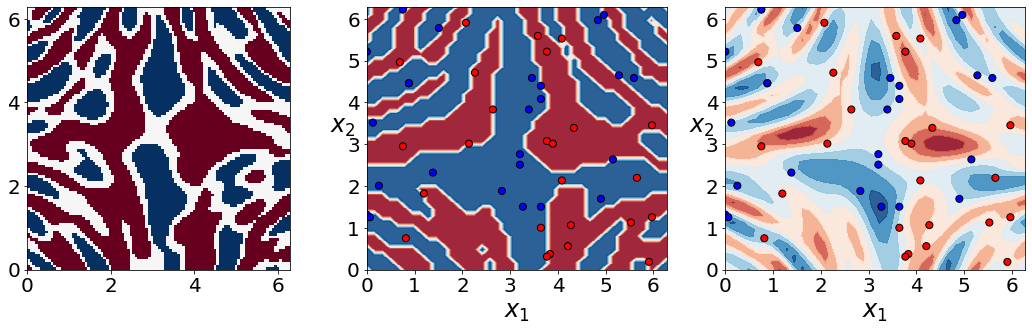

In [23]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=1,
    gates=['ry', 'rx', 'cz', ], entanglement='linear',
    repeat=True, scale=True, alpha=2.0,
)

for i in range(2):
    fm.h(i)
    fm.rz(fm.encod_params[i], i)

for i in range(2, fm.num_qubits):
    t = 2.0*(np.pi-fm.encod_params[i%fm.num_features]/fm.alpha)*(np.pi-fm.encod_params[(i+1)%fm.num_features]/fm.alpha)
    fm.h(i)
    fm.rz(t, i)

print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌──────────┐            ┌───────────────┐ ┌───────────────────────────────┐
q_0: ┤ Ry(θ[1]) ├───■────────┤ Rz(x[0]*θ[0]) ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     ├──────────┤ ┌─┴─┐      ├───────────────┤ ├───────────────────────────────┤
q_1: ┤ Ry(θ[2]) ├─┤ X ├──■───┤ Rz(x[1]*θ[0]) ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     ├──────────┤ └───┘┌─┴─┐ ├───────────────┤ ├───────────────────────────────┤
q_2: ┤ Ry(θ[3]) ├───■──┤ X ├─┤ Rz(x[0]*θ[0]) ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     ├──────────┤ ┌─┴─┐└───┘ ├───────────────┤ ├───────────────────────────────┤
q_3: ┤ Ry(θ[4]) ├─┤ X ├──────┤ Rz(x[1]*θ[0]) ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     └──────────┘ └───┘      └───────────────┘ └───────────────────────────────┘


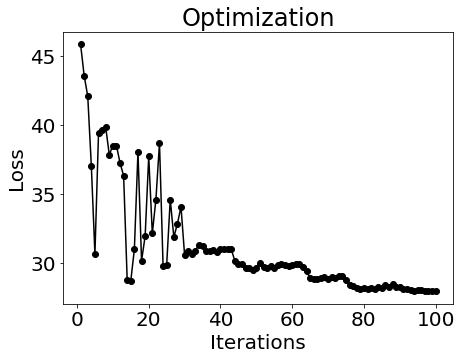


Train scores:
   Balanced accuracy:  0.86
                  F1:  0.86
             ROC_AUC:  0.88
                 MCC:  0.72

Test scores:
   Balanced accuracy:  0.56
                  F1:  0.55
             ROC_AUC:  0.55
                 MCC:  0.13


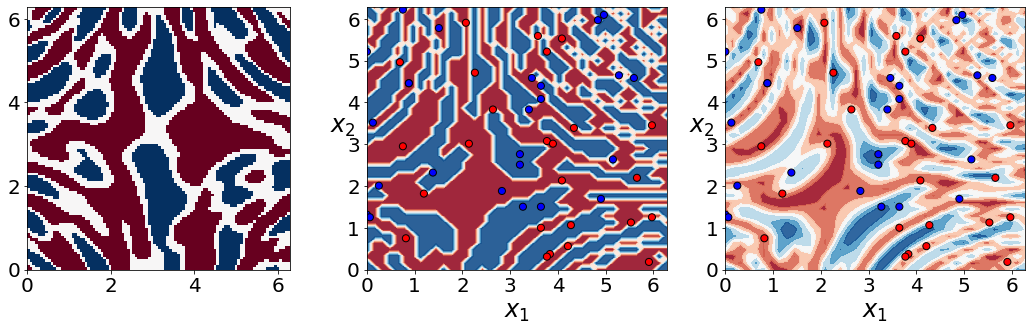

In [24]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=1,
    gates=['ry', 'cx', 'RZ', ], entanglement='linear',
    repeat=True, scale=True, alpha=2.0,
)

for i in range(fm.num_qubits):
    t = 2.0*(np.pi-fm.encod_params[i%fm.num_features]/fm.alpha)*(np.pi-fm.encod_params[(i+1)%fm.num_features]/fm.alpha)
    fm.rz(t, i)

# fm = fm.compose(fm)
    
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌──────────┐             ┌──────────┐                     ┌───────────────┐        
q_0: ┤ Rx(θ[1]) ├──────■──────┤ Rx(θ[5]) ├─────────────────────┤ Rz(x[0]*θ[0]) ├────────
     ├──────────┤ ┌────┴─────┐└────┬─────┘                     ├───────────────┤        
q_1: ┤ Rx(θ[2]) ├─┤ Rx(θ[4]) ├─────┼───────────■───────────────┤ Rz(x[1]*θ[0]) ├────────
     ├──────────┤ └──────────┘     │      ┌────┴─────┐ ┌───────┴───────────────┴───────┐
q_2: ┤ Rx(θ[3]) ├──────────────────■──────┤ Rx(θ[6]) ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     └──────────┘                         └──────────┘ └───────────────────────────────┘


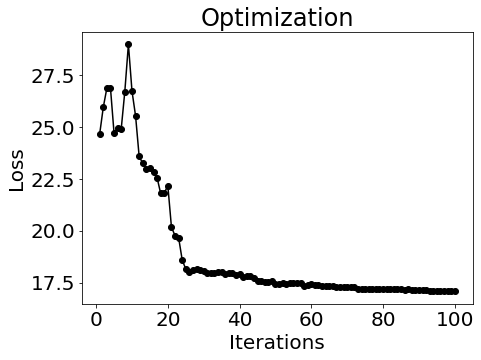


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.88
                 MCC:  0.56


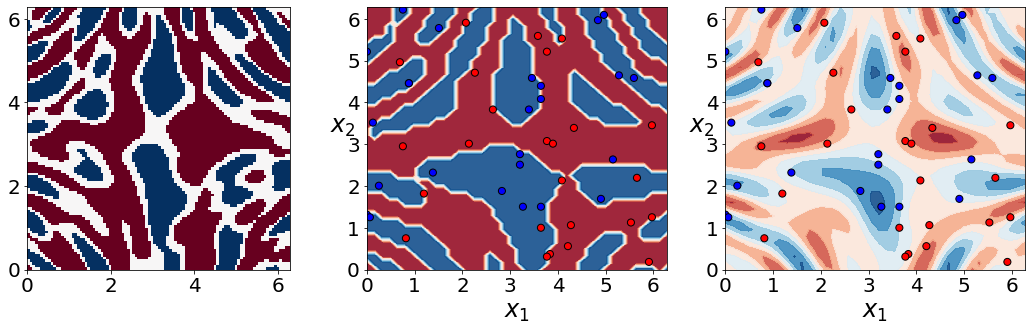

In [25]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=3,
    num_layers=1,
    gates=['rx', 'crx', ], entanglement='ring',
    repeat=False, scale=True, alpha=2.0,
)

for i in range(fm.num_features):
    fm.rz(fm.encod_params[i], i)

t = 2.0*(np.pi-fm.encod_params[0]/fm.alpha)*(np.pi-fm.encod_params[1]/fm.alpha)
fm.rz(t, 2)

# fm = fm.compose(fm)
    
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌──────────┐ ┌──────────┐        ┌───┐         ┌───────────────┐        
q_0: ┤ Rx(θ[1]) ├─┤ Rz(θ[5]) ├──■─────┤ H ├─────────┤ Rz(x[0]*θ[0]) ├────────
     ├──────────┤ ├──────────┤  │     ├───┤         ├───────────────┤        
q_1: ┤ Rx(θ[2]) ├─┤ Rz(θ[6]) ├──■──■──┤ H ├─────────┤ Rz(x[1]*θ[0]) ├────────
     ├──────────┤ ├──────────┤     │  ├───┤ ┌───────┴───────────────┴───────┐
q_2: ┤ Rx(θ[3]) ├─┤ Rz(θ[7]) ├──■──■──┤ H ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     ├──────────┤ ├──────────┤  │     ├───┤ ├───────────────────────────────┤
q_3: ┤ Rx(θ[4]) ├─┤ Rz(θ[8]) ├──■─────┤ H ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     └──────────┘ └──────────┘        └───┘ └───────────────────────────────┘


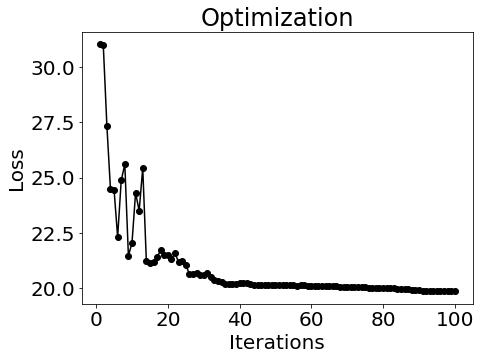


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.82
                  F1:  0.82
             ROC_AUC:  0.91
                 MCC:  0.65


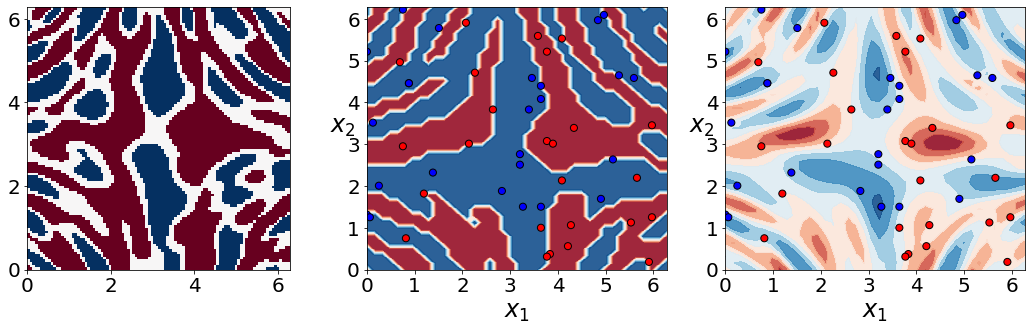

In [26]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=1,
    gates=['rx', 'rz', 'cz', 'h' ], entanglement='linear',
    repeat=False, scale=True, alpha=2.0,
)

for i in range(fm.num_features):
    fm.rz(fm.encod_params[i], i)

t = 2.0*(np.pi-fm.encod_params[0]/fm.alpha)*(np.pi-fm.encod_params[1]/fm.alpha)
fm.rz(t, 2)
fm.rz(t, 3)

print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌──────────┐  ┌──────────┐        ┌───┐         ┌───────────────┐        
q_0: ┤ Rx(θ[1]) ├──┤ Rz(θ[6]) ├──■─────┤ H ├─────────┤ Rz(x[0]*θ[0]) ├────────
     ├──────────┤  ├──────────┤  │     ├───┤         ├───────────────┤        
q_1: ┤ Rx(θ[2]) ├──┤ Rz(θ[7]) ├──■──■──┤ H ├─────────┤ Rz(x[1]*θ[0]) ├────────
     ├──────────┤  ├──────────┤     │  ├───┤       ┌─┴───────────────┴─┐      
q_2: ┤ Rx(θ[3]) ├──┤ Rz(θ[8]) ├──■──■──┤ H ├───────┤ Rz(2π - 2.0*x[0]) ├──────
     ├──────────┤  ├──────────┤  │     ├───┤       ├───────────────────┤      
q_3: ┤ Rx(θ[4]) ├──┤ Rz(θ[9]) ├──■──■──┤ H ├───────┤ Rz(2π - 2.0*x[1]) ├──────
     ├──────────┤ ┌┴──────────┤     │  ├───┤ ┌─────┴───────────────────┴─────┐
q_4: ┤ Rx(θ[5]) ├─┤ Rz(θ[10]) ├─────■──┤ H ├─┤ Rz(2.0*(π - x[0])*(π - x[1])) ├
     └──────────┘ └───────────┘        └───┘ └───────────────────────────────┘


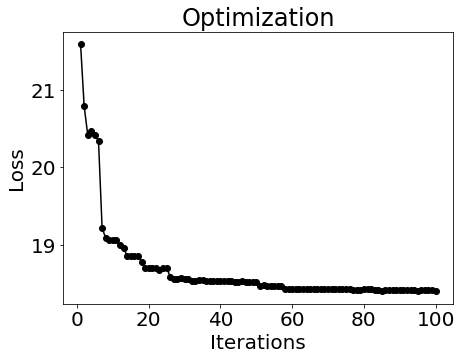


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.94
                  F1:  0.94
             ROC_AUC:  0.95
                 MCC:  0.88


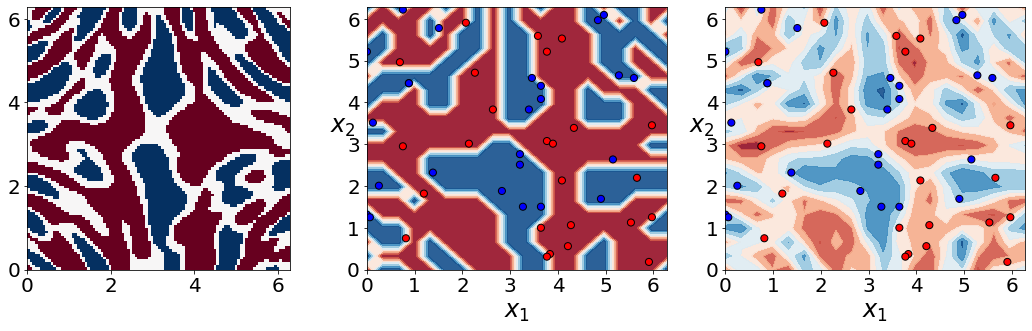

In [28]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=5,
    num_layers=1,
    gates=['rx', 'rz', 'cz', 'h' ], entanglement='linear',
    repeat=False, scale=True, alpha=2.0,
)

for i in range(fm.num_features):
    fm.rz(fm.encod_params[i], i)

tx = np.pi-fm.encod_params[0]/fm.alpha
ty = np.pi-fm.encod_params[1]/fm.alpha

tt = 2.0*tx
fm.rz(tt, 2)

tt = 2.0*ty
fm.rz(tt, 3)

tt = 2.0*tx*ty
fm.rz(tt, 4)

print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

(400, 3)
(50, 3) (50, 3)
Training target statistics: Counter({1: 25, -1: 25})
Testing target statistics: Counter({-1: 25, 1: 25})
     ┌──────────┐             ┌──────────┐             ┌───────────────┐ 
q_0: ┤ Rx(θ[1]) ├──────■──────┤ Rx(θ[5]) ├─────────────┤ Rz(x[0]*θ[0]) ├─
     ├──────────┤ ┌────┴─────┐└────┬─────┘             ├───────────────┤ 
q_1: ┤ Rx(θ[2]) ├─┤ Rx(θ[4]) ├─────┼───────────■───────┤ Rz(x[1]*θ[0]) ├─
     ├──────────┤ └──────────┘     │      ┌────┴─────┐ ├───────────────┤ 
q_2: ┤ Rx(θ[3]) ├──────────────────■──────┤ Rx(θ[6]) ├─┤ Rz(x[2]*θ[0]) ├─
     └──────────┘                         └──────────┘ └───────────────┘ 


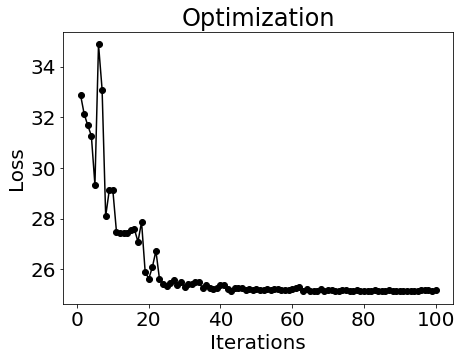


Train scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.95
                 MCC:  0.77

Test scores:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.80
                 MCC:  0.56


In [29]:
# Add 1 more data dimension

m, n = X.shape
X_1 = np.zeros((m, n+1))
X_1[:,:n] = X[:,:]
X_1[:,n] = 2.0*(np.pi-X[:,0])*(np.pi-X[:,1])
print(X_1.shape)

train_size = 50
test_size = 50
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_1, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(X_train_1.shape, X_test_1.shape)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")


fm = QuantumFeatureMap(
    num_features=len(X_1[0]), 
    num_qubits=3,
    num_layers=1,
    gates=['rx', 'crx', 'RZ'], entanglement='ring',
    repeat=True, scale=True, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train_1, y_train_1, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train_1, y_train_1)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test_1, y_test_1)
print_scores(test_scores, title='Test scores:')

# plot_results(qsvc, N=40)